# Clustering using LSH
> **Documentation:** [Locality Sensitive Hasing](https://spark.apache.org/docs/2.2.0/ml-features.html#locality-sensitive-hashing)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/30 17:52:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/30 17:52:17 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/parquet_files

Sat Mar 30 17:52:20 UTC 2024
gs://dsgt-clef-plantclef-2024/data/parquet_files/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_1/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_4/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized_v2/


In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
train = "PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the Train parquet file
train_gcs_path = f"{gcs_path}{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

# Show the data (for example, first few rows)
train_df.show(n=3)

+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+--------------------+
|          image_name|                path| organ|species_id|    obs_id|             license|partner|              author|altitude|     latitude|    longitude|gbif_species_id|             species|     genus|       family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|                data|
+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+-----------

In [41]:
# Select columns
cols = ["image_name", "latitude", "longitude", "species", "species_id"]
local_df = train_df.select(cols).cache()
local_df.show(n=3)

+--------------------+-------------+-------------+--------------------+----------+
|          image_name|     latitude|    longitude|             species|species_id|
+--------------------+-------------+-------------+--------------------+----------+
|2fb34c40832bffad3...|         NULL|         NULL|Posidonia oceanic...|   1361703|
|38da078be8660b772...|     43.59753|     -8.12915|Arctotheca calend...|   1355927|
|4fe98ed9eff6eed40...|38.6945228605|-9.2953275237|Podranea ricasoli...|   1388692|
+--------------------+-------------+-------------+--------------------+----------+
only showing top 3 rows



In [35]:
from pyspark.sql import functions as F


def count_latitude_longitude_rows(df, verbose=True):
    # Count rows where 'latitude' and 'longitude' is NULL
    lat_null_count = df.filter(F.col("latitude").isNull()).count()
    long_null_count = df.filter(F.col("longitude").isNull()).count()

    # Count rows where either 'latitude' or 'longitude' is NULL
    null_lat_long_count = df.filter(
        F.col("latitude").isNull() | F.col("longitude").isNull()
    ).count()

    if verbose:
        print(f"Latitude NULL count: {lat_null_count}")
        print(f"Longitude NULL count: {long_null_count}")
        print(f"Rows with NULL latitude or longitude: {null_lat_long_count}")


# Print results
count_latitude_longitude_rows(df=local_df)

Latitude NULL count: 702608
Longitude NULL count: 702592
Rows with NULL latitude or longitude: 702609


In [7]:
# Filter rows where 'species' is not NULL and count distinct species
distinct_species_count = (
    train_df.where(F.col("latitude").isNotNull() & F.col("longitude").isNotNull())
    .select(F.col("species"))
    .distinct()
    .count()
)

total_species_count = train_df.select(F.col("species")).distinct().count()

# Print
print(f"Total number of species: {total_species_count}")
print(f"Number of distinct species with non-NULL values: {distinct_species_count}")

Total number of species: 7855
Number of distinct species with non-NULL values: 6246


In [8]:
# Create a DataFrame to see species imbalance
species_df = (
    local_df.select(F.col("species"))
    .groupBy(F.col("species"))
    .count()
    .withColumnRenamed("count", "species_count")
    .orderBy(F.col("species_count").desc())
)

# Show DF
species_df.show(n=20)
species_df.orderBy(F.col("species_count")).show(n=20)

+--------------------+-------------+
|             species|species_count|
+--------------------+-------------+
|Styphnolobium jap...|          823|
|Frangula alnus Mill.|          793|
|Aria edulis (Will...|          770|
|Lathyrus oleraceu...|          700|
|  Bromus sterilis L.|          674|
|   Lotus hirsutus L.|          668|
|Scandosorbus inte...|          662|
|     Hedera helix L.|          653|
|Oxalis dillenii J...|          653|
|Calicotome spinos...|          642|
|Castanea sativa M...|          638|
|Buxus semperviren...|          636|
|    Arbutus unedo L.|          634|
|Pistacia lentiscu...|          632|
|   Ulmus minor Mill.|          630|
|Tecomaria capensi...|          627|
|     Quercus ilex L.|          626|
|Calamagrostis are...|          625|
|Pittosporum tobir...|          625|
|Cercis siliquastr...|          624|
+--------------------+-------------+
only showing top 20 rows



+--------------------+-------------+
|             species|species_count|
+--------------------+-------------+
|Papaver confine J...|            1|
|Genista tribracte...|            1|
|Galium valentinum...|            1|
|Delphinium bolosi...|            1|
|Festuca liviensis...|            1|
| Centaurea pinae Pau|            1|
|Poa × austrohercy...|            1|
| Crocus clusii J.Gay|            1|
|           Cardamine|            1|
|Anchusa puechii V...|            1|
|           Equisetum|            1|
|Myosotis soleirol...|            1|
|Armeria muelleri ...|            1|
|Trisetaria aurea ...|            1|
|Pilosella pilosel...|            1|
|Helianthemum papi...|            1|
|Orobanche portoil...|            1|
|Trisetaria macroc...|            1|
|             Populus|            1|
|Koeleria caudata ...|            1|
+--------------------+-------------+
only showing top 20 rows



In [45]:
# Filter data where 'latitude' and 'longitude' is not NULL
geo_local_df = local_df.where(
    F.col("latitude").isNotNull() & F.col("longitude").isNotNull()
)
sub_species_df = (
    geo_local_df.groupBy("species", "species_id")
    .agg(F.count("*").alias("n"))
    .where(F.col("n") > 100)
    .orderBy(F.rand(seed=42))
    .limit(10)
).cache()
sub_species_df.show(truncate=80)

# Sub local
sub_local_df = geo_local_df.join(
    sub_species_df.select("species_id"),
    "species_id",
)
sub_local_df.show(truncate=80)

24/03/30 18:40:51 WARN CacheManager: Asked to cache already cached data.


+-------------------------------------+----------+---+
|                              species|species_id|  n|
+-------------------------------------+----------+---+
|                 Lathyrus hirsutus L.|   1363800|161|
|             Salvia rosmarinus Spenn.|   1722409|304|
|      Luzula sylvatica (Huds.) Gaudin|   1397430|254|
|                 Alchemilla alpina L.|   1397279|194|
|                  Veronica montana L.|   1359979|178|
|  Hedysarum boveanum Bunge ex Basiner|   1359231|105|
|Echinops bannaticus Rochel ex Schrad.|   1398631|146|
|         Oenanthe aquatica (L.) Poir.|   1393990|156|
|                    Rumex × acutus L.|   1737469|139|
|                Pistacia lentiscus L.|   1356290|364|
+-------------------------------------+----------+---+

+----------+--------------------------------------------+------------------+------------------+--------------------+
|species_id|                                  image_name|          latitude|         longitude|             spec

## Locality Sensitive Hashing

In [65]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import BucketedRandomProjectionLSH

# Combine latitude and longitude into a single vector column
vectorAssembler = VectorAssembler(
    inputCols=["latitude", "longitude"], outputCol="features"
)

# Standardize the features
standardScaler = StandardScaler(
    inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True
)

# Apply LSH
brpLSH = BucketedRandomProjectionLSH(
    inputCol="scaledFeatures", outputCol="hashes", bucketLength=20.0, numHashTables=5
)

# Create Pipeline
pipeline = Pipeline(stages=[vectorAssembler, standardScaler, brpLSH])

# Fit pipeline to DF
model = pipeline.fit(sub_local_df)

# Apply the model to transform the DF
transformed_df = model.transform(sub_local_df).cache()

# Show results
transformed_df.show(n=10)

+----------+--------------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+
|species_id|          image_name|         latitude|         longitude|             species|            features|      scaledFeatures|              hashes|
+----------+--------------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+
|   1397279|799cfaae6ee06aa6f...|      61.74781701|        9.04809128|Alchemilla alpina L.|[61.74781701,9.04...|[1.65744995107132...|[[0.0], [0.0], [0...|
|   1397279|de429917248253c3e...|    47.4581228519|     13.6214842559|Alchemilla alpina L.|[47.4581228519,13...|[0.28317921955357...|[[-1.0], [0.0], [...|
|   1397279|e8e7afdaee271cc1c...|44.19662777777778|10.714066666666666|Alchemilla alpina L.|[44.1966277777777...|[-0.0304858016683...|[[-1.0], [0.0], [...|
|   1397279|ba882a8ad8f7d8e34...|46.48377897222223| 12.04464547222222|

In [66]:
# Extract LSH from the pipeline
brpLSHModel = model.stages[-1]

# Perform an approximate similarity join with itself
threshold = 1.5
approx_sim_df = brpLSHModel.approxSimilarityJoin(
    transformed_df, transformed_df, threshold, distCol="EuclideanDistance"
)

# Show results
approx_sim_df.select(
    "datasetA.latitude", "datasetA.longitude", "datasetB.latitude", "datasetB.longitude"
).show()

+-------------+-------------+-----------------+-------------------+
|     latitude|    longitude|         latitude|          longitude|
+-------------+-------------+-----------------+-------------------+
|  61.74781701|   9.04809128|    51.8792324649|        0.184025484|
|  61.74781701|   9.04809128|     51.027271964|      13.7293154783|
|  61.74781701|   9.04809128|47.34424297222223| 10.124325972222223|
|47.4581228519|13.6214842559|       44.5391033| 21.066291599722224|
|47.4581228519|13.6214842559|45.73704166666667|  7.293115555555556|
|47.4581228519|13.6214842559|        42.297627|           3.273926|
|47.4581228519|13.6214842559|         36.58484|           10.41516|
|47.4581228519|13.6214842559|      36.71975708|-3.4609961508333336|
|47.4581228519|13.6214842559|41.01809308333333| 0.6998999722222222|
|47.4581228519|13.6214842559|       43.7428091|          5.4510811|
|47.4581228519|13.6214842559|47.05441429972222|          9.7467909|
|47.4581228519|13.6214842559|         45.88082| 

In [64]:
approx_sim_df.groupBy("datasetA.image_name").agg(
    F.count("datasetB.image_name").alias("n")
).select(F.mean("n")).show()

+-----------------+
|           avg(n)|
+-----------------+
|1478.785107446277|
+-----------------+



In [62]:
# Avg. num of neighbors from approxSimilarityJoin to be 20 to 100
# Want enough neighbors to see local topology, but not too many
# Count of similarity join divided by original count squared
k_n = 2900000 / 2000
print(k_n)

1450.0


In [71]:
import time
import numpy as np


# Function to measure search
def approx_sim_search(transformed_df, threshold):
    data = {}
    for t in threshold:
        # Perform an approximate similarity join with itself for a threshold range
        approx_sim_df = brpLSHModel.approxSimilarityJoin(
            transformed_df, transformed_df, t, distCol="EuclideanDistance"
        )
        start = time.time()
        approx_count = approx_sim_df.count()
        end = time.time()
        run_time = end - start
        data[t] = [run_time, approx_count]
    return data


# Run function
threshold = np.arange(0.1, 1.1, 0.1)
data = approx_sim_search(transformed_df, threshold)

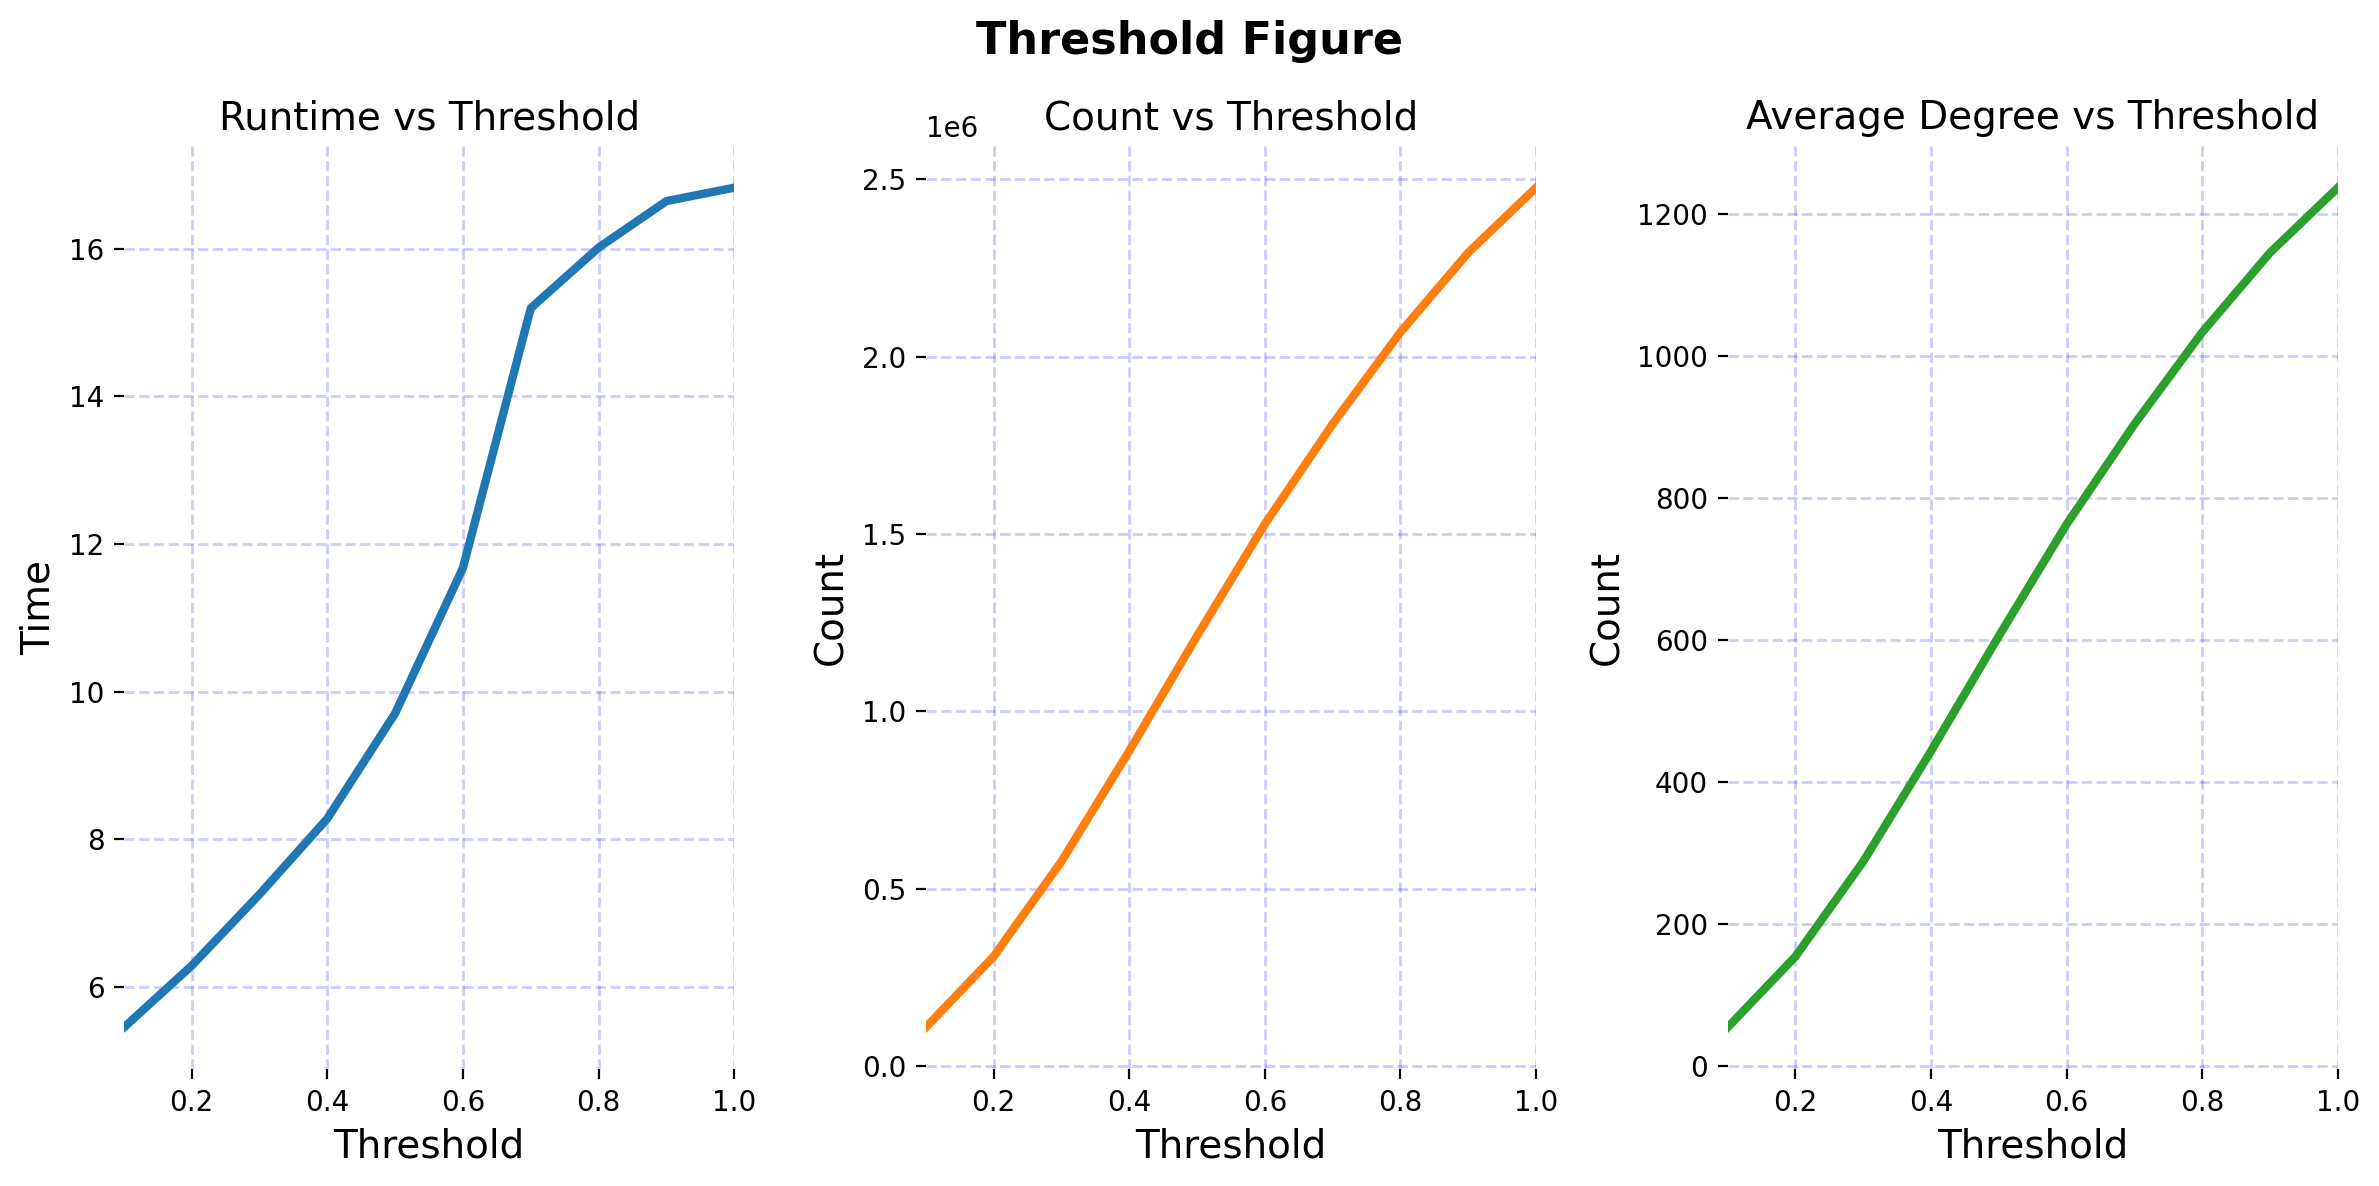

In [97]:
import matplotlib.pyplot as plt

original_count = transformed_df.count()
thresholds = list(data.keys())
times = [v[0] for v in data.values()]
counts = [v[1] for v in data.values()]
avg_degree = [v[1] / original_count for v in data.values()]
plot_data = [(thresholds, times), (thresholds, counts), (thresholds, avg_degree)]

# Make figure
fig, axs = plt.subplots(1, 3, figsize=(12, 6), dpi=200)
fig.suptitle("Threshold Figure", weight="bold", fontsize=16)
titles = ["Runtime vs Threshold", "Count vs Threshold", "Average Degree vs Threshold"]
colors = ["tab:blue", "tab:orange", "tab:green"]

# Plot time vs threshold
for i, ax in enumerate(axs.flat):
    ax.plot(plot_data[i][0], plot_data[i][1], linewidth=3, color=colors[i])
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Threshold", fontsize=14)
    ax.set_ylabel("Time" if i == 0 else "Count", fontsize=14)
    ax.margins(x=0, y=0.05)  # No margins on x and y-axis
    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    spines = ["top", "right", "bottom", "left"]
    for s in spines:
        ax.spines[s].set_visible(False)
fig.tight_layout()
plt.show()